In [2]:
import pandas as pd
import numpy as np
from plotnine import *

dms_results = pd.read_csv("../antibody_dms_merge.csv")
site_sum = dms_results.groupby(['site','antibody']).sum().reset_index()
sites_total_sum = site_sum.groupby('antibody')['mut_escape'].sum().to_dict()
site_sum = site_sum.assign(site_total = lambda x: [sites_total_sum[y] for y in x['antibody']]).assign(mut_escape = lambda x: x['mut_escape']/x['site_total']).drop(columns=['site_total'])


,site,antibody,mut_escape
0,331,BD30-604,0.140013
1,331,BD45-105,0.164676
2,331,BD45-145,0.728541
3,331,BD45-147,0.014166
4,331,BD45-152,0.203890
...,...,...,...
225977,531,SN1854,0.038355
225978,531,SN1867,0.215676
225979,531,SN1884,0.084733
225980,531,SN1926,0.284671


In [10]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances

site_mat = site_sum.pivot(index='antibody', columns='site', values='mut_escape').fillna(0)
dist = pd.DataFrame(pairwise_distances(site_mat.to_numpy(), metric=jensenshannon), index=site_mat.index, columns=site_mat.index)
dist.index.name = None


array([[0.        , 0.58211662, 0.53698895, ..., 0.63344235, 0.32811694,
        0.33226912],
       [0.58211662, 0.        , 0.40933704, ..., 0.5596372 , 0.49730177,
        0.53977616],
       [0.53698895, 0.40933704, 0.        , ..., 0.54524629, 0.41248509,
        0.50285381],
       ...,
       [0.63344235, 0.5596372 , 0.54524629, ..., 0.        , 0.5652235 ,
        0.60800169],
       [0.32811694, 0.49730177, 0.41248509, ..., 0.5652235 , 0.        ,
        0.2273645 ],
       [0.33226912, 0.53977616, 0.50285381, ..., 0.60800169, 0.2273645 ,
        0.        ]])

In [25]:
import igraph as ig

class DMSProfileGraph(ig.Graph):
    r'''
    An igraph.Graph object with neccessary metadata and attributes about DMS experiments.
    Each node in the graph represents a DMS profile (instead of an antibody). There may
    be multiple DMS profiles for one antibody.
    
    Initiation
    ----------
    edges
        a pd.DataFrame object with 3 columns: 'index', 'variable', 'value', indicating the 
        distances of node 'index' and node 'variable'
    
    '''
    def __init__(self, edges_df):
        nodes = pd.unique(edges_df['index'])
        self.sample2node = {}
        self.node2sample = {}
        edges_node = set()
        
        for i in range(len(nodes)):
            self.node2sample[i] = nodes[i]
            self.sample2node[nodes[i]] = i
        
        for u, v, w in edges_df.to_numpy():
            _u = self.sample2node[u]
            _v = self.sample2node[v]
            edges_node.add((min(_u,_v), max(_u,_v)))
            
        super().__init__(n = len(nodes), edges = edges_node)
        
    def __len__(self):
        return len(self.sample2node)

In [27]:
n_neighbors = 12
edges = (
    dist.reset_index().melt(id_vars="index")
        .query('index != variable').sort_values('value',ascending=True)
        .groupby('index').head(n_neighbors)
        .reset_index(drop=True)
)
knn_graph = DMSProfileGraph(edges_df = edges)

In [33]:
import umap
import leidenalg as la

embedding = pd.DataFrame(
    umap.UMAP(n_neighbors=n_neighbors, min_dist=0.8, metric='precomputed', random_state=20230417).fit_transform(dist),
    columns=["UMAP1","UMAP2"]
)
embedding['antibody'] = dist.index
embedding.index = [knn_graph.sample2node[i] for i in dist.index]

partition = la.find_partition(knn_graph, partition_type=la.RBConfigurationVertexPartition, resolution_parameter=1.2, seed=20230417).membership
embedding['cluster'] = [str(partition[i]) for i in embedding.index]
cluster_rename = pd.Series(
    [
        'A1',
        'D3',
        'E3',
        'A2',
        'F1',
        'B',
        'E3',
        'F3',
        'E2.2',
        'F1',
        'E1/E2.1',
        'D2',
        'F1',
        'D4',
        'C/D1',
    ],
    index=np.unique(embedding['cluster'])
).to_dict()
embedding = embedding.sort_values('antibody').reset_index(drop=True).assign(group=lambda x:[cluster_rename[y] for y in x['cluster']])
embedding

/share/home/jianfc/miniconda3/envs/COVID/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable


,UMAP1,UMAP2,antibody,cluster,group
0,11.326628,10.864877,BD30-604,0,A1
1,-0.535671,2.744734,BD45-105,10,E3
2,7.389261,-0.158994,BD45-145,1,D3
3,4.368710,-1.019701,BD45-147,5,E1/E2.1
4,10.087426,0.771621,BD45-152,6,D2
...,...,...,...,...,...
1345,12.547091,8.247333,SN1854,0,A1
1346,1.101415,7.467105,SN1867,7,F1
1347,1.286911,7.974662,SN1884,7,F1
1348,11.233230,8.797884,SN1926,0,A1


In [34]:
# label the antibodies with high uncertainty on clustering

groups = embedding.set_index('antibody')['group'].to_dict()

x = dist.melt(ignore_index=False).reset_index().rename(columns={'index':'antibody','variable':'neighbor'}).sort_values(['antibody','value']).groupby('antibody').head(10).assign(
    neighbor_group=lambda x:[groups[i] for i in x['neighbor']]
).groupby(['antibody','neighbor_group'])['neighbor'].count().reset_index().assign(group=lambda x: [groups[i] for i in x['antibody']]).query('neighbor < 10').sort_values('neighbor', ascending=False)

confidence = x.query('neighbor_group == group').set_index('antibody',drop=True).assign(conf = lambda x: x['neighbor']/10)['conf'].to_dict()
second_groups = x.query('neighbor_group != group').groupby('antibody').first()['neighbor_group'].to_dict()

embedding = embedding.assign(confidence=lambda x: [confidence[i] if i in confidence else 1.0 for i in x['antibody']], 
         second_group = lambda x:[second_groups[i] if i in second_groups else pd.NA for i in x['antibody']])

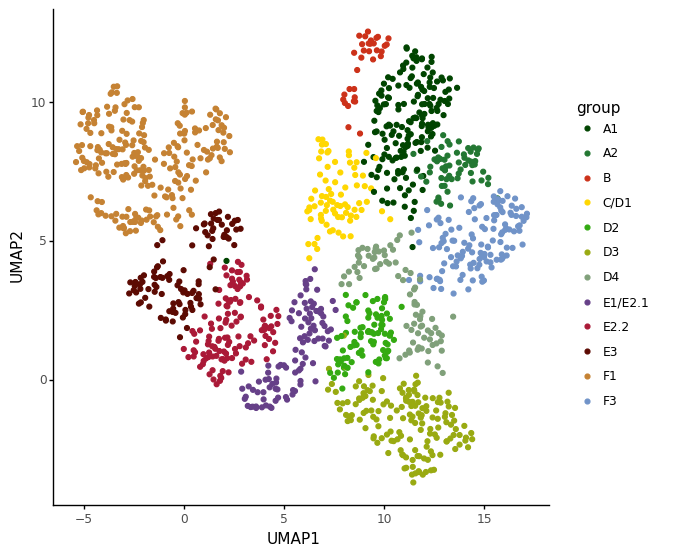

/share/home/jianfc/miniconda3/envs/COVID/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 982 rows containing missing values.
/share/home/jianfc/miniconda3/envs/COVID/lib/python3.7/site-packages/plotnine/guides/guides.py:261: PlotnineWarning: geom_point legend : Removed 1 rows containing missing values.


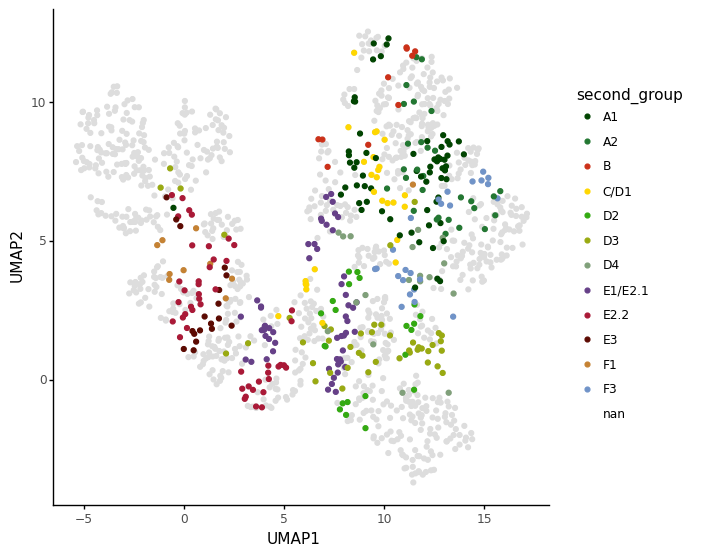

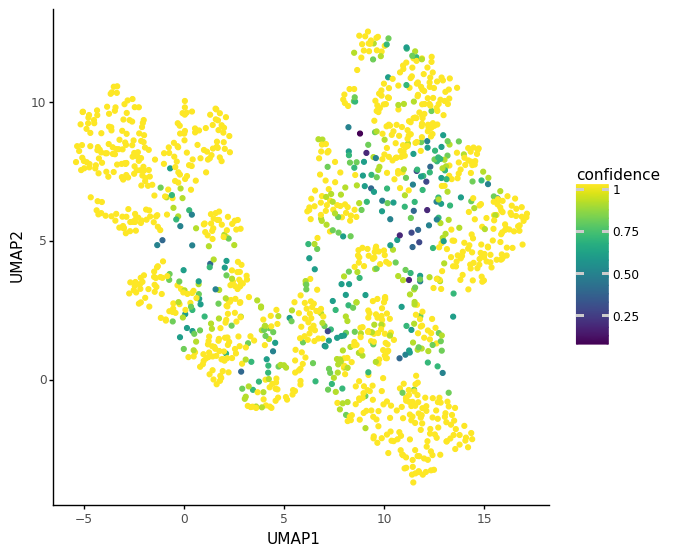

In [37]:
colors = {
    "A1":"#004400","A2":"#237732",
    "B":"#CC3119",
    "C/D1":"#ffd700",
    "D2":"#33aa11", "D3":"#99AA11","D4":"#80A07A",
    "E1/E2.1":"#664088", 
    "E2.2":'#aa1937', 
    "E3":"#5c0a02",
    "F1":"#c58233",
    "F3":"#7093c8",
}

print(
    ggplot(embedding, aes('UMAP1','UMAP2'))+geom_point(aes(color='group'))+theme_classic()+theme(aspect_ratio=1.0)+scale_color_manual(colors),
    ggplot(embedding, aes('UMAP1','UMAP2'))+geom_point(color='#DDDDDD')+geom_point(aes(color='second_group'))+theme_classic()+theme(aspect_ratio=1.0)+scale_color_manual(colors),
    ggplot(embedding, aes('UMAP1','UMAP2'))+geom_point(aes(color='confidence'))+theme_classic()+theme(aspect_ratio=1.0)
)

In [39]:
embedding.to_csv("./antibody_clusters.csv",index=None)